In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Time Series Analysis/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters/weekly_customer_complaints.csv',index_col='week',parse_dates=True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [3]:
df['complaints'] = df['complaints'].str.replace(',', '').astype(int)
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype(float)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26,1,0,0
2018-01-08,1701,35.38,0,0,0
2018-01-15,1711,36.22,1,0,0
2018-01-22,1443,38.33,1,0,0
2018-01-29,1397,36.34,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   complaints               261 non-null    int64  
 1   discount_rate            261 non-null    float64
 2   small_commercial_event   261 non-null    int64  
 3   medium_commercial_event  261 non-null    int64  
 4   big_commercial_event     261 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 12.2 KB


# Initial EDA

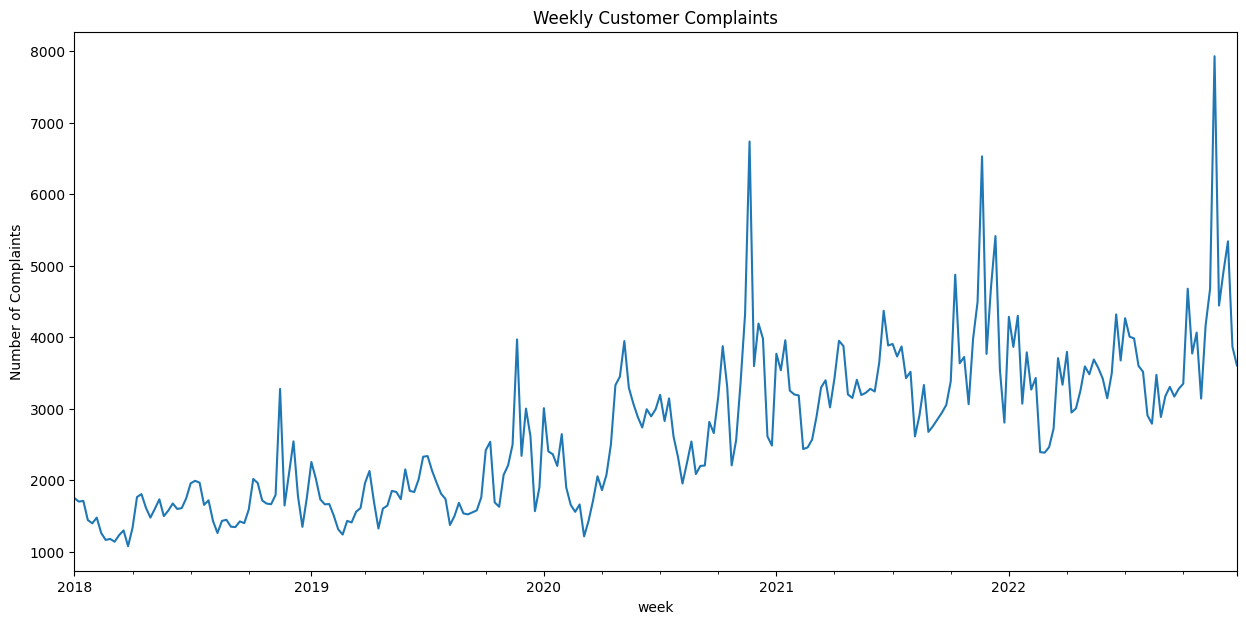

In [5]:
df['complaints'].plot(figsize=(15,7))
plt.ylabel('Number of Complaints')
plt.title('Weekly Customer Complaints')
plt.show()

7-Day Rolling Average Plot

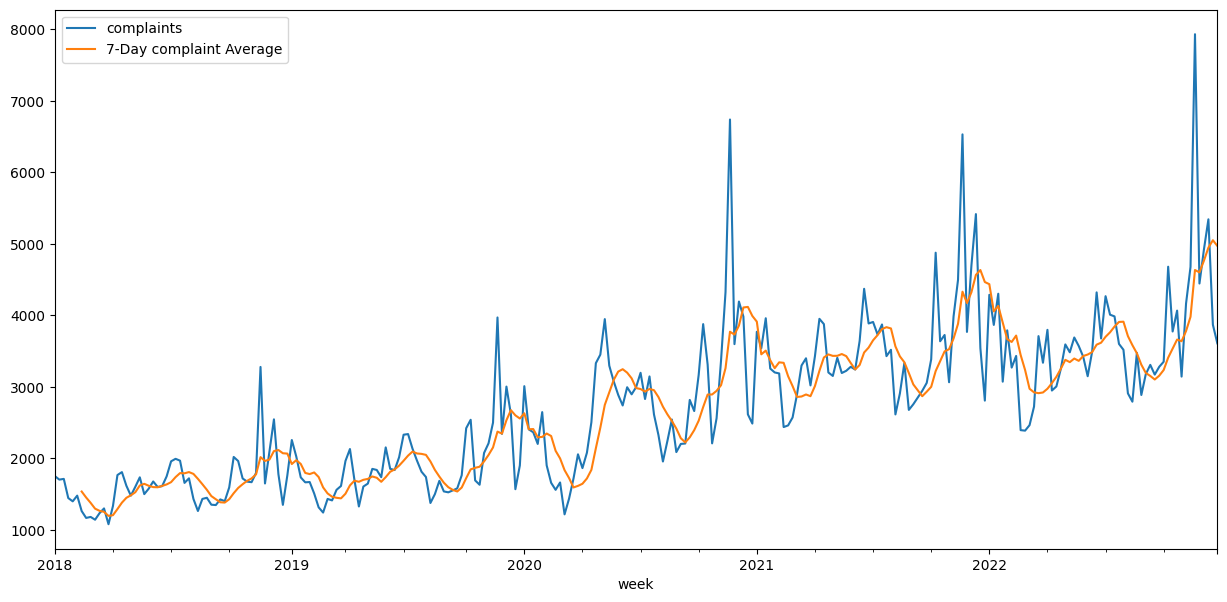

In [6]:
df['7-Day complaint Average'] = df['complaints'].rolling(window=7).mean()
df[['complaints', '7-Day complaint Average']].plot(figsize=(15,7))
plt.show()

Let's find the month with the highest complaint average.

In [7]:
df.resample('ME').mean()['complaints'].idxmax()

Timestamp('2022-11-30 00:00:00')

Percentage change from month to month

In [8]:
df['Pct Change'] = df['complaints'].pct_change()
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event,7-Day complaint Average,Pct Change
week,,,,,,,
2018-01-01,1750,37.26,1,0,0,NaN,NaN
2018-01-08,1701,35.38,0,0,0,NaN,-0.028000
2018-01-15,1711,36.22,1,0,0,NaN,0.005879
2018-01-22,1443,38.33,1,0,0,NaN,-0.156634
2018-01-29,1397,36.34,0,0,0,NaN,-0.031878


Filter for dates where percentage change (+ or -) is greater than 10%

In [9]:
df[abs(df['Pct Change']) > 0.1]

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event,7-Day complaint Average,Pct Change
week,,,,,,,
2018-01-22,1443,38.33,1,0,0,NaN,-0.156634
2018-02-12,1261,35.22,1,0,0,1534.285714,-0.146242
2018-03-26,1077,20.40,1,0,0,1193.142857,-0.170262
2018-04-02,1333,25.18,0,0,0,1203.428571,0.237697
2018-04-09,1765,25.83,1,0,0,1289.142857,0.324081
...,...,...,...,...,...,...,...
2022-11-14,4677,34.24,0,0,0,3978.571429,0.123199
2022-11-21,7931,37.59,0,0,0,4633.000000,0.695745
2022-11-28,4444,29.89,0,1,0,4599.428571,-0.439667


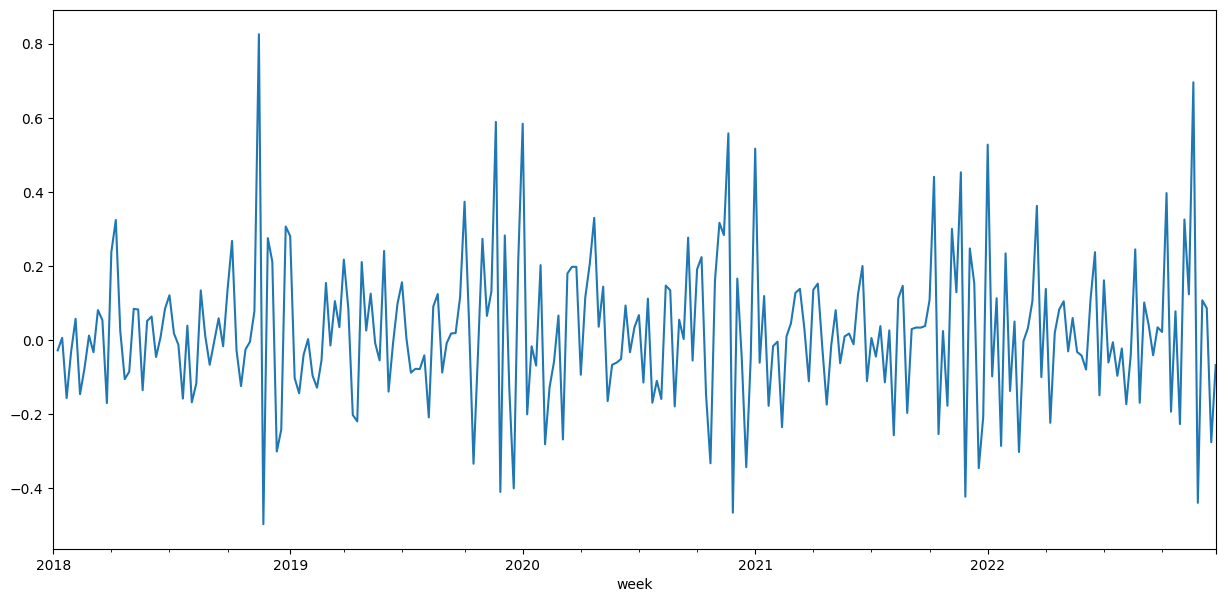

In [10]:
df['Pct Change'].plot(figsize=(15,7))
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   complaints               261 non-null    int64  
 1   discount_rate            261 non-null    float64
 2   small_commercial_event   261 non-null    int64  
 3   medium_commercial_event  261 non-null    int64  
 4   big_commercial_event     261 non-null    int64  
 5   7-Day complaint Average  255 non-null    float64
 6   Pct Change               260 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 16.3 KB


In [12]:
df['7-Day complaint Average'] = df['7-Day complaint Average'].interpolate(limit_direction='backward')
df.isnull().sum()

,0
complaints,0
discount_rate,0
small_commercial_event,0
medium_commercial_event,0
big_commercial_event,0
7-Day complaint Average,0
Pct Change,1


Get year, month and day from index

In [13]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['weekday_name'] = df.index.day_name()
df['week'] = df.index.isocalendar().week
df['quarter'] = df.index.quarter
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event,7-Day complaint Average,Pct Change,year,month,day,dayofweek,weekday_name,week,quarter
week,,,,,,,,,,,,,,
2018-01-01,1750,37.26,1,0,0,1534.285714,NaN,2018,1,1,0,Monday,1,1
2018-01-08,1701,35.38,0,0,0,1534.285714,-0.028000,2018,1,8,0,Monday,2,1
2018-01-15,1711,36.22,1,0,0,1534.285714,0.005879,2018,1,15,0,Monday,3,1
2018-01-22,1443,38.33,1,0,0,1534.285714,-0.156634,2018,1,22,0,Monday,4,1
2018-01-29,1397,36.34,0,0,0,1534.285714,-0.031878,2018,1,29,0,Monday,5,1


# Lagged Variables

In [14]:
df['complaints Lag 1'] = df['complaints'].shift(1)
df['complaints Lag 2'] = df['complaints'].shift(2)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event,7-Day complaint Average,Pct Change,year,month,day,dayofweek,weekday_name,week,quarter,complaints Lag 1,complaints Lag 2
week,,,,,,,,,,,,,,,,
2018-01-01,1750,37.26,1,0,0,1534.285714,NaN,2018,1,1,0,Monday,1,1,NaN,NaN
2018-01-08,1701,35.38,0,0,0,1534.285714,-0.028000,2018,1,8,0,Monday,2,1,1750.0,NaN
2018-01-15,1711,36.22,1,0,0,1534.285714,0.005879,2018,1,15,0,Monday,3,1,1701.0,1750.0
2018-01-22,1443,38.33,1,0,0,1534.285714,-0.156634,2018,1,22,0,Monday,4,1,1711.0,1701.0
2018-01-29,1397,36.34,0,0,0,1534.285714,-0.031878,2018,1,29,0,Monday,5,1,1443.0,1711.0


# Complaint Seasonality

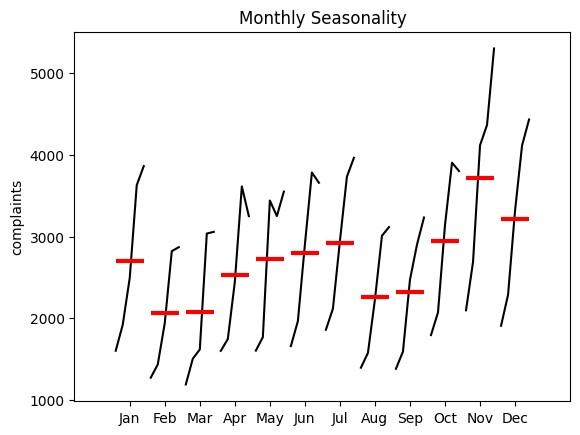

In [15]:
# Monthly Seasonality
month_plot(df['complaints'].resample('ME').mean())
plt.title('Monthly Seasonality')
plt.ylabel('complaints')
plt.show()

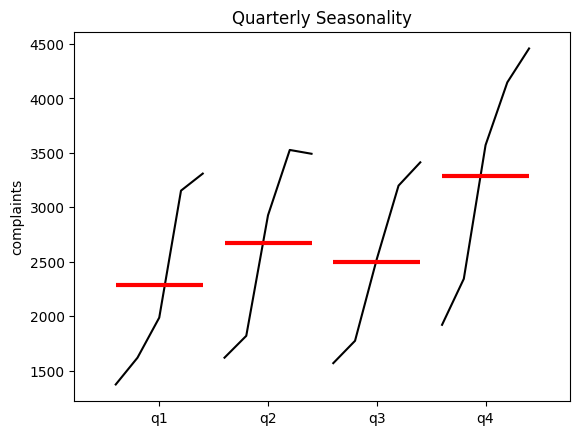

In [16]:
# Quarterly Seasonality

quarter_plot(df['complaints'].resample('QE').mean())
plt.title('Quarterly Seasonality')
plt.ylabel('complaints')
plt.show()

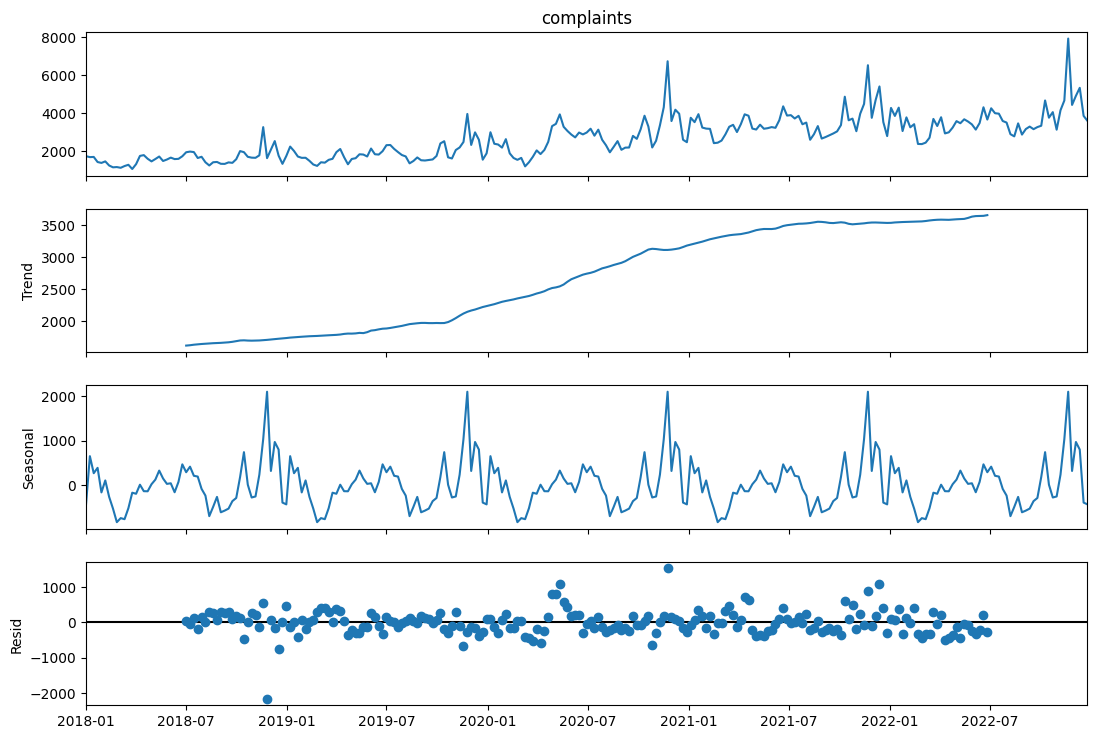

In [17]:
# Seasonal decomposition of 'complaints'  (52 week period)
result = seasonal_decompose(df['complaints'], model='additive', period=52)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

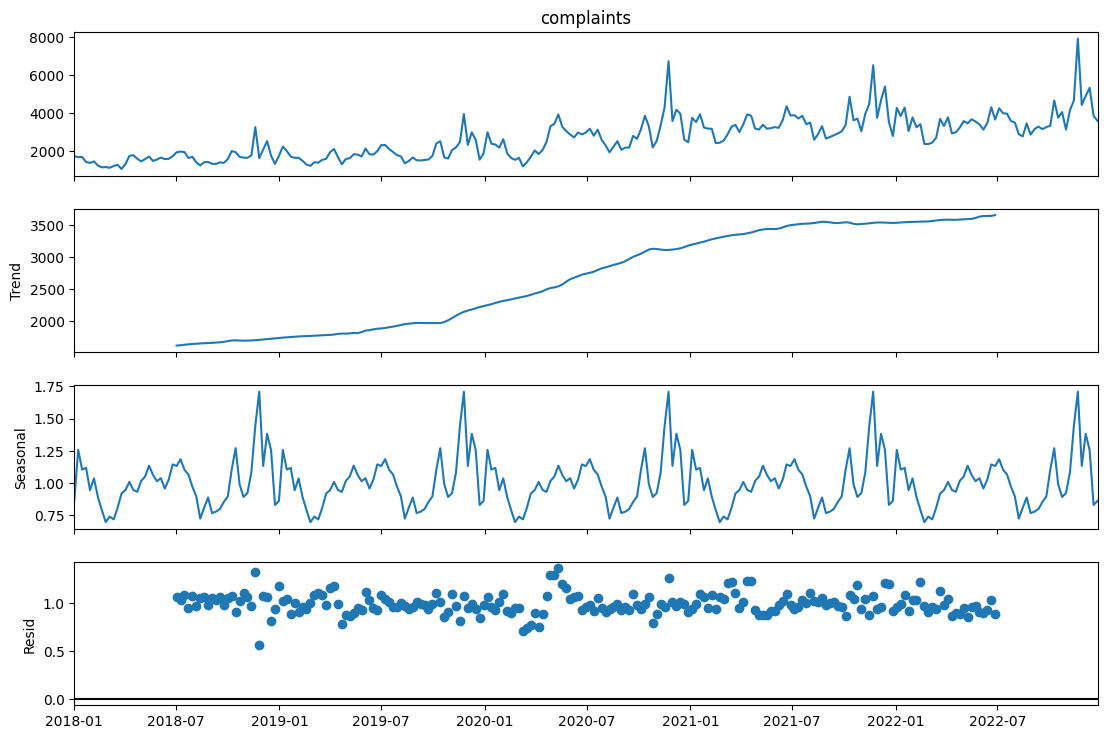

In [18]:
# Seasonal decomposition of 'complaints'
result = seasonal_decompose(df['complaints'], model='multiplicative', period=52)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

# Auto-Correlation Function (ACF)

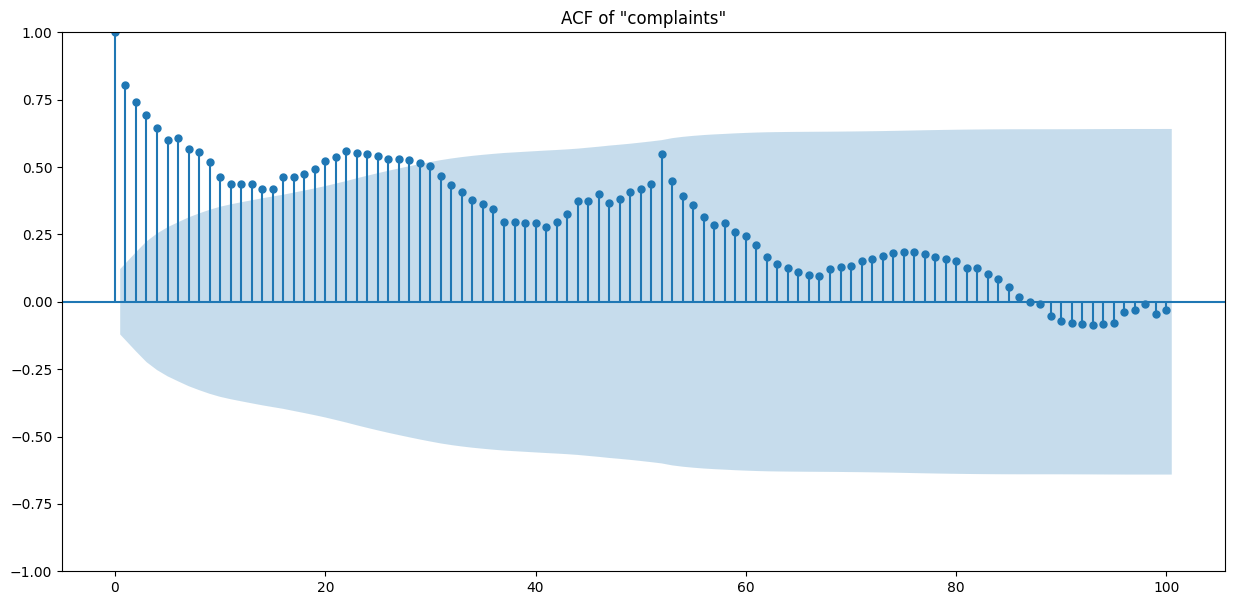

In [19]:
# Plot the ACF for the 'complaints' data
fig, ax = plt.subplots(figsize=(15,7))
plot_acf(df['complaints'], lags=100, ax=ax)
plt.title('ACF of "complaints"')
plt.show()

# Partial Auto-Correlation (PACF)

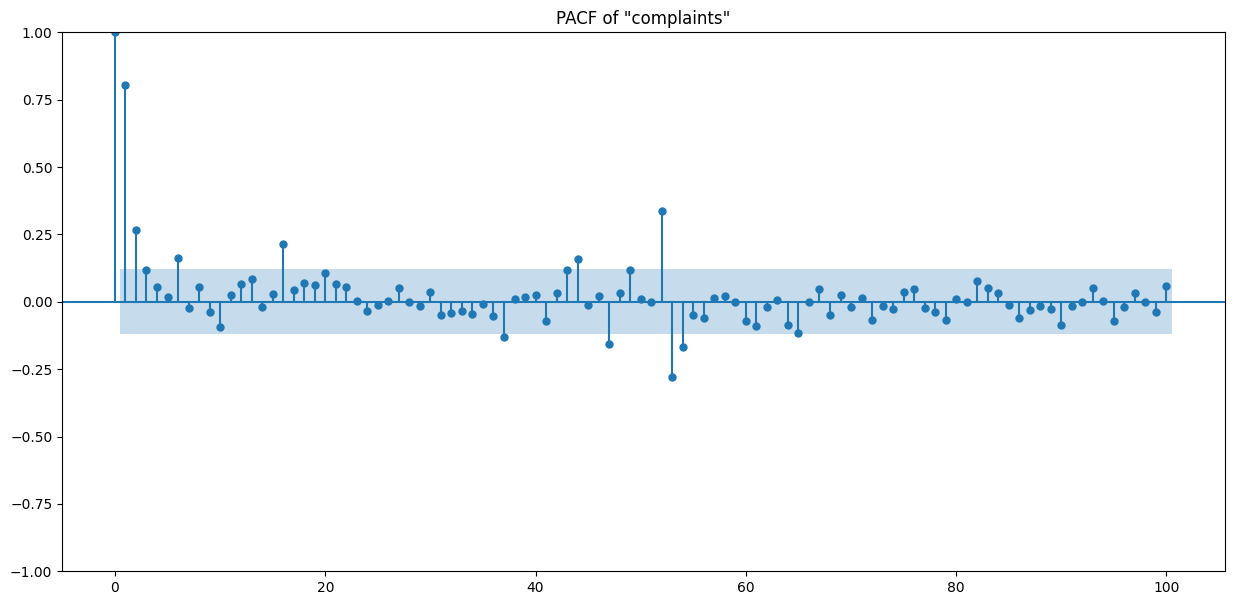

In [20]:
# PACF 'complaints'
fig, ax = plt.subplots(figsize=(15,7))
plot_pacf(df['complaints'], lags=100, ax=ax)
plt.title('PACF of "complaints"')
plt.show()

# Print the frequency of time series

In [21]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

In [22]:
# Change the frequency to 'W-Mon' (2018-01-01 was a Monday)
df = df.asfreq('W-Mon')
df.index


DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq='W-MON')

# Goal: predict the number of complaints over the next 13 weeks

1. Split data into training and test datasets.

In [23]:
periods = 13
train = df[:-periods].complaints
test = df[-periods:].complaints

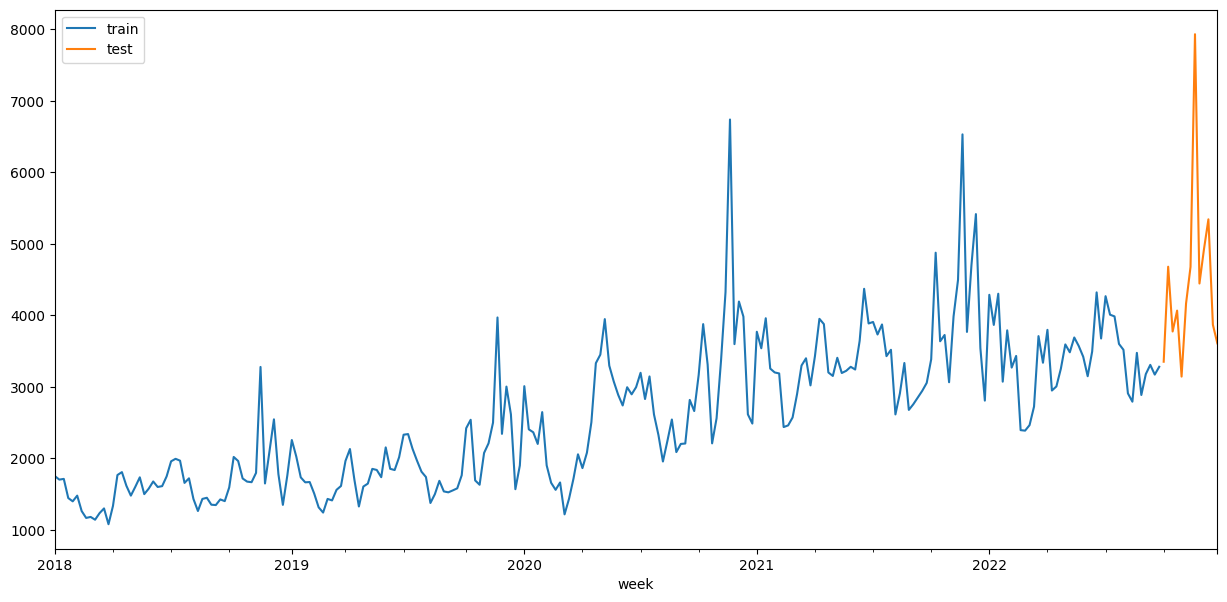

In [24]:
train.plot(figsize=(15,7))
test.plot(figsize=(15,7))
plt.legend(['train', 'test'])
plt.show()

In [25]:
train.tail()

,complaints
week,
2022-08-29,2885
2022-09-05,3177
2022-09-12,3306
2022-09-19,3170
2022-09-26,3279


In [26]:
test.head()

,complaints
week,
2022-10-03,3350
2022-10-10,4679
2022-10-17,3773
2022-10-24,4065
2022-10-31,3142


# Apply Simple Exponential Smoothing to the train dataset

In [27]:
# Apply SES to train dataset
ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:             complaints   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355648.448
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Thu, 10 Jul 2025
Box-Cox:                        False   Time:                         16:30:56
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5115116                alpha                 True
initial_level              1750.0000                

In [28]:
# Generate predictions
ses_pred = ses_model.predict(start=test.index[0], end=test.index[-1])
ses_pred

,0
2022-10-03,3236.834414
2022-10-10,3236.834414
2022-10-17,3236.834414
2022-10-24,3236.834414
2022-10-31,3236.834414
2022-11-07,3236.834414
2022-11-14,3236.834414
2022-11-21,3236.834414
2022-11-28,3236.834414
2022-12-05,3236.834414


Plot train, test and predictions....it's terrible!

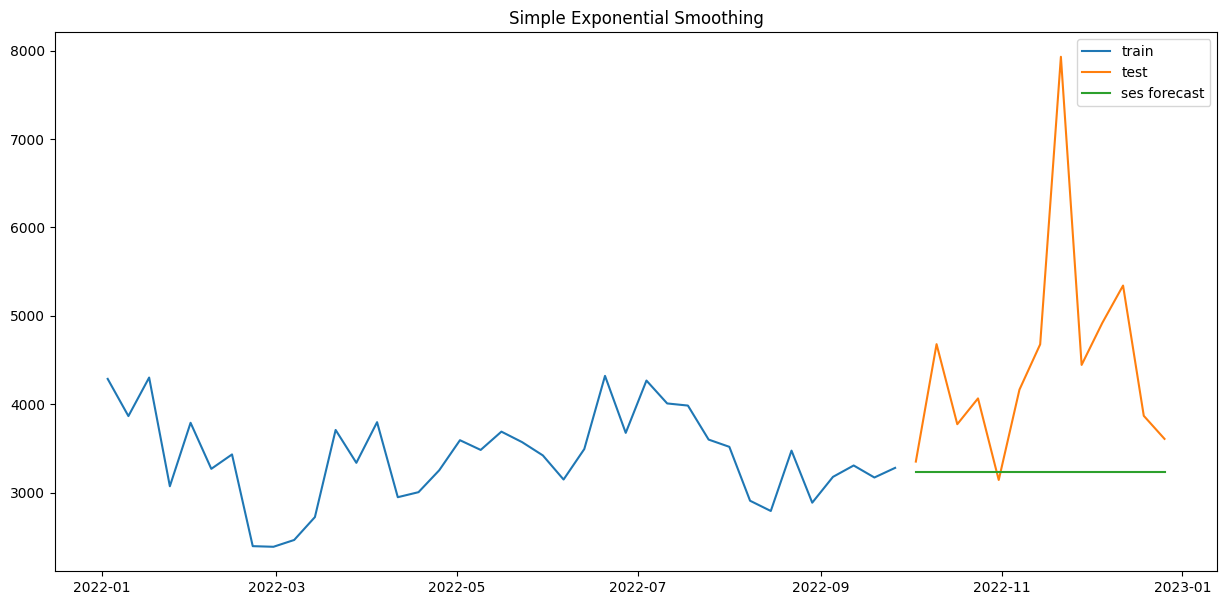

In [29]:
plt.figure(figsize=(15,7))
plt.plot(train.loc['2022'], label='train')
plt.plot(test, label='test')
plt.plot(ses_pred, label='ses forecast')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

# Double Exponential Smoothing

In [30]:
# Build double exponential smoothing model

des_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=52).fit()
print(des_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               complaints   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       30968251.679
Optimized:                         True   AIC                           3022.291
Trend:                         Additive   BIC                           3219.043
Seasonal:                      Additive   AICC                          3058.503
Seasonal Periods:                    52   Date:                 Thu, 10 Jul 2025
Box-Cox:                          False   Time:                         16:30:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2192299                alpha                 True
smoothing_trend          

In [31]:
# Generate predictions
des_pred = des_model.predict(start=test.index[0], end=test.index[-1])

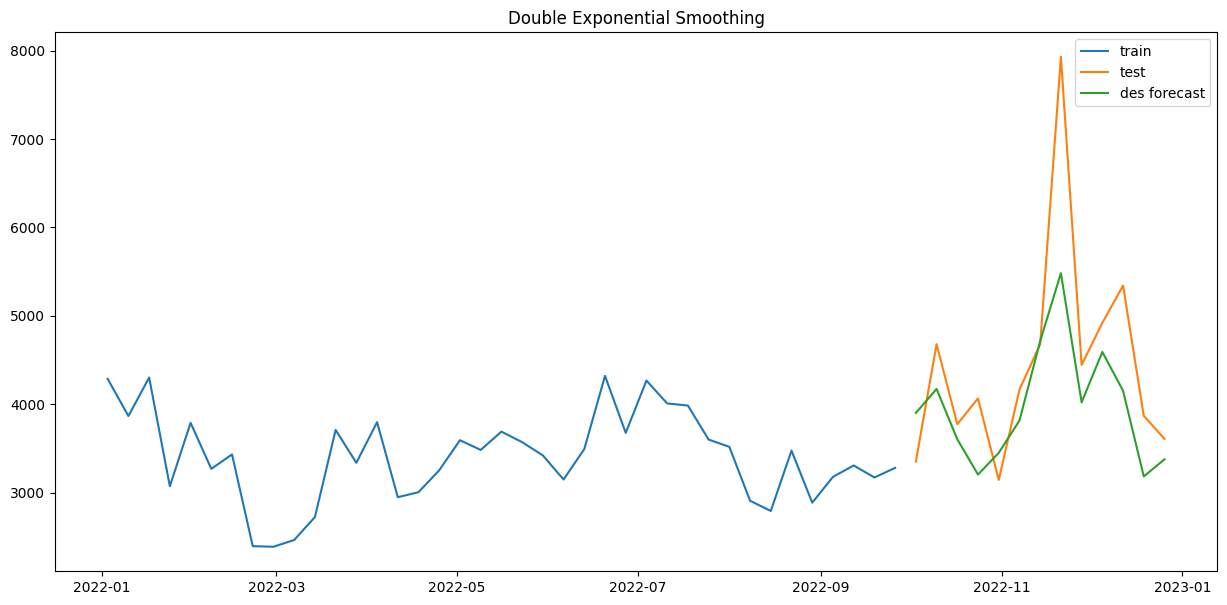

In [32]:
plt.figure(figsize=(15,7))
plt.plot(train.loc['2022'], label='train')
plt.plot(test, label='test')
plt.plot(des_pred, label='des forecast')
plt.title('Double Exponential Smoothing')
plt.legend()
plt.show()

# Triple Exponential Smoothing - Holt Winters


In [33]:
# Build triple exponential smoothing model

tes_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=52).fit()
print(tes_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               complaints   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       22025740.634
Optimized:                         True   AIC                           2937.785
Trend:                         Additive   BIC                           3134.537
Seasonal:                Multiplicative   AICC                          2973.996
Seasonal Periods:                    52   Date:                 Thu, 10 Jul 2025
Box-Cox:                          False   Time:                         16:30:58
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2171429                alpha                 True
smoothing_trend          

In [34]:
# Generate predictions
tes_pred = tes_model.predict(start=test.index[0], end=test.index[-1])

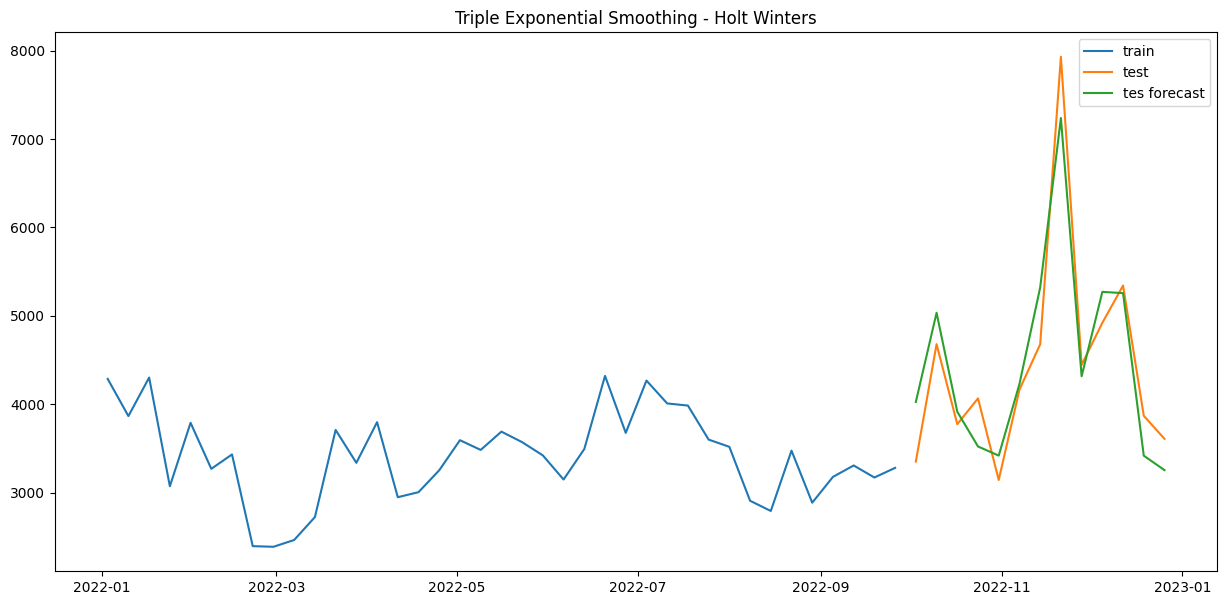

In [35]:
plt.figure(figsize=(15,7))
plt.plot(train.loc['2022'], label='train')
plt.plot(test, label='test')
plt.plot(tes_pred, label='tes forecast')
plt.title('Triple Exponential Smoothing - Holt Winters')
plt.legend()
plt.show()

# Let's calculate some metrics on the model predictions...

In [36]:
# MAPE
mape_tes = np.mean(np.abs(test - tes_pred) / test) * 100
mape_des = np.mean(np.abs(test - des_pred) / test) * 100
mape_ses = np.mean(np.abs(test - ses_pred) / test) * 100
print(f'MAPE for Triple Exponential Smoothing - Holt Winters: {mape_tes:.2f}%')
print(f'MAPE for Double Exponential Smoothing: {mape_des:.2f}%')
print(f'MAPE for Simple Exponential Smoothing: {mape_ses:.2f}%')

MAPE for Triple Exponential Smoothing - Holt Winters: 8.52%
MAPE for Double Exponential Smoothing: 12.73%
MAPE for Simple Exponential Smoothing: 23.95%


In [37]:
# MAE

mae_tes = mean_absolute_error(test, tes_pred)
mae_des = mean_absolute_error(test, des_pred)
mae_ses = mean_absolute_error(test, ses_pred)
print(f'MAE for Triple Exponential Smoothing - Holt Winters: {mae_tes:.2f}')
print(f'MAE for Double Exponential Smoothing: {mae_des:.2f}')
print(f'MAE for Simple Exponential Smoothing: {mae_ses:.2f}')

MAE for Triple Exponential Smoothing - Holt Winters: 366.14
MAE for Double Exponential Smoothing: 622.49
MAE for Simple Exponential Smoothing: 1236.37


In [38]:
# RMSE

rmse_tes = root_mean_squared_error(test, tes_pred)
rmse_des = root_mean_squared_error(test, des_pred)
rmse_ses = root_mean_squared_error(test, ses_pred)
print(f'RMSE for Triple Exponential Smoothing - Holt Winters: {rmse_tes:.2f}')
print(f'RMSE for Double Exponential Smoothing: {rmse_des:.2f}')
print(f'RMSE for Simple Exponential Smoothing: {rmse_ses:.2f}')

RMSE for Triple Exponential Smoothing - Holt Winters: 424.83
RMSE for Double Exponential Smoothing: 867.10
RMSE for Simple Exponential Smoothing: 1693.91


In [65]:
# Let's functionalize the model assessment

def model_assess(train, test, pred, chart_title=None):
  plt.figure(figsize=(15,7))
  plt.plot(train, label='train')
  plt.plot(test, label='test')
  plt.plot(pred, label='forecast')
  plt.show()

  mape = np.mean(np.abs(test - pred) / test) * 100
  mae = mean_absolute_error(test, pred)
  rmse = root_mean_squared_error(test, pred)
  print(f'\nMAPE: {mape:.2f}%')
  print(f'MAE: {mae:.2f}')
  print(f'RMSE: {rmse:.2f}\n\n')
  return

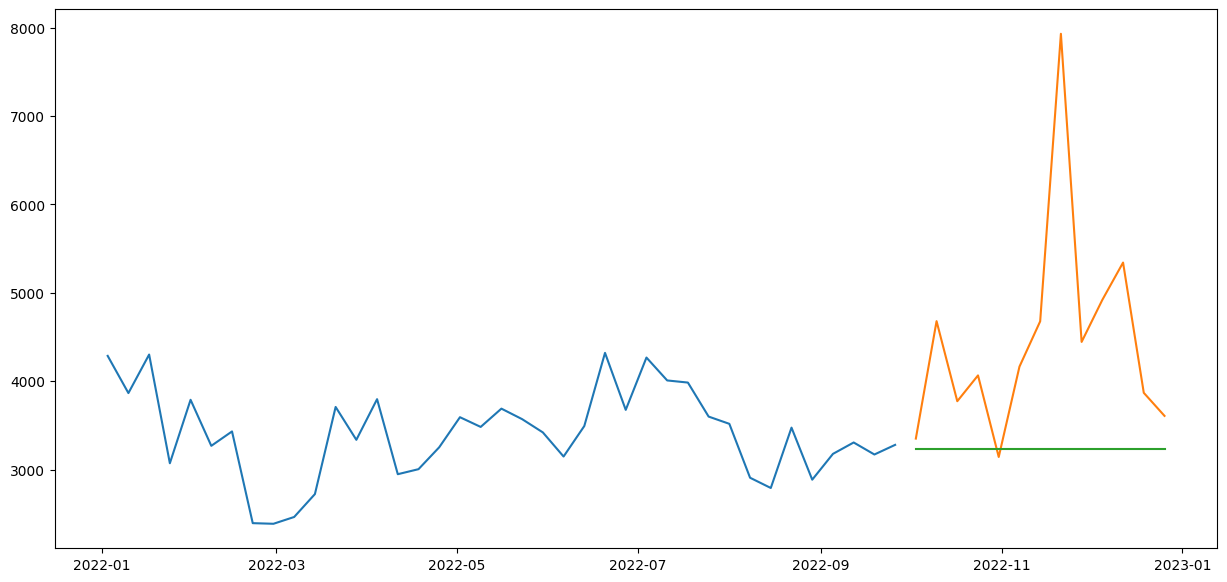


MAPE: 23.95%
MAE: 1236.37
RMSE: 1693.91




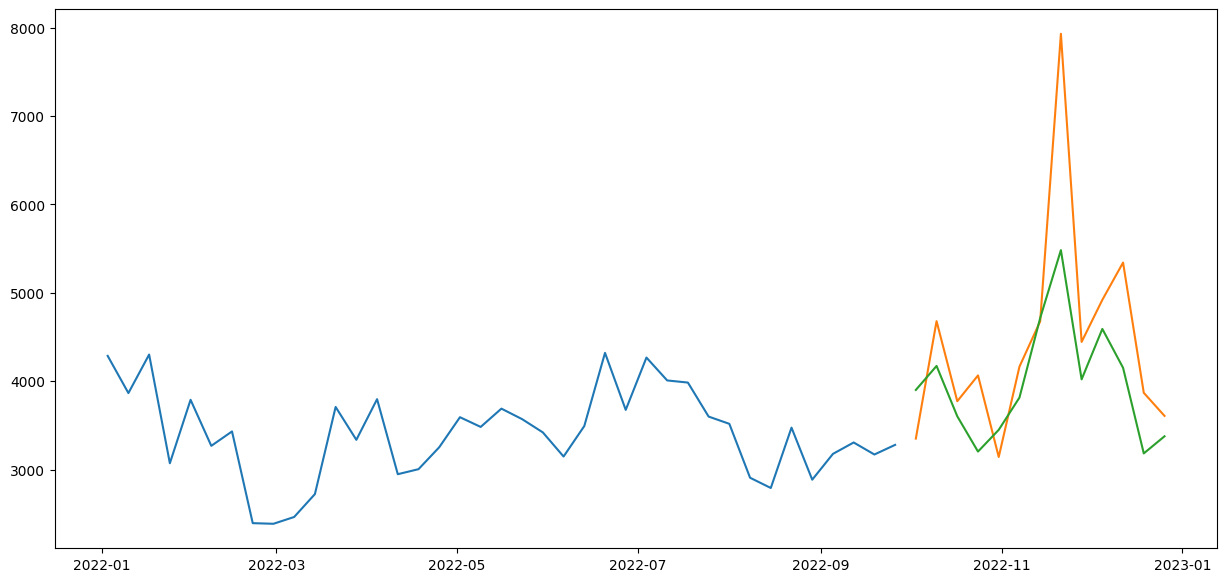


MAPE: 12.73%
MAE: 622.49
RMSE: 867.10




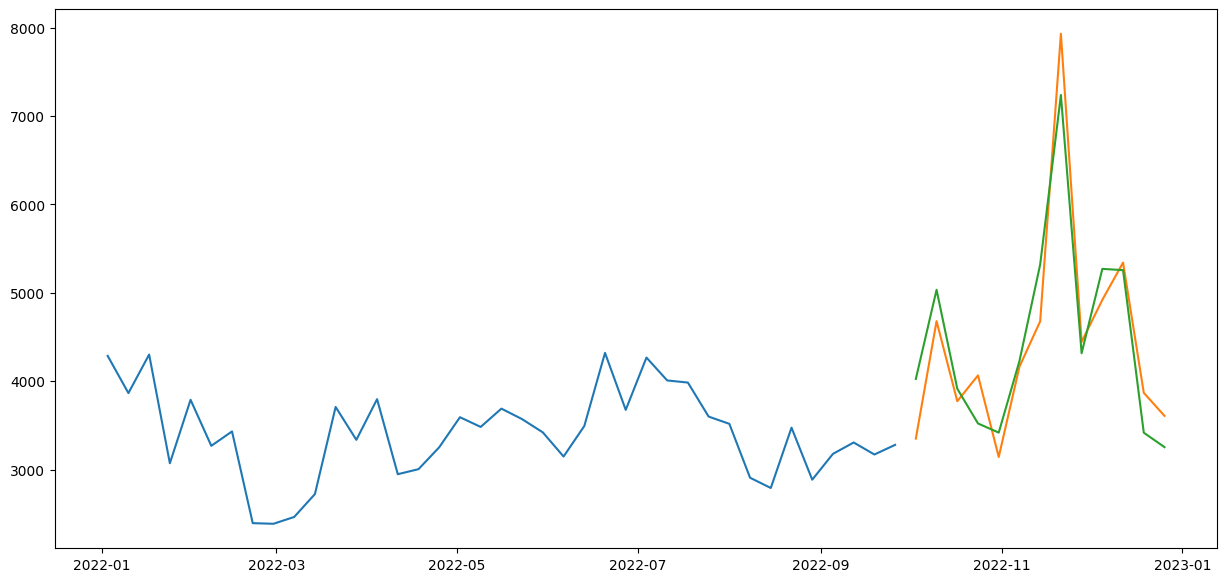


MAPE: 8.52%
MAE: 366.14
RMSE: 424.83




(None, None, None)

In [40]:
model_assess(train, test, ses_pred, 'Simple Exponential Smoothing'), model_assess(train, test, des_pred, 'Double Exponential Smoothing'), model_assess(train, test, tes_pred, 'Triple Exponential Smoothing - Holt Winters')

Train the model with the **complete** complaint dataset.

# Make future predictions using the model

In [41]:
# Explore the data

X = df.complaints
X.head()

,complaints
week,
2018-01-01,1750
2018-01-08,1701
2018-01-15,1711
2018-01-22,1443
2018-01-29,1397


In [42]:
# Train the model
tes_model = ExponentialSmoothing(X, trend='add', seasonal='mul', seasonal_periods=52).fit()
print(tes_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               complaints   No. Observations:                  261
Model:             ExponentialSmoothing   SSE                       24398356.310
Optimized:                         True   AIC                           3099.277
Trend:                         Additive   BIC                           3298.890
Seasonal:                Multiplicative   AICC                          3133.158
Seasonal Periods:                    52   Date:                 Thu, 10 Jul 2025
Box-Cox:                          False   Time:                         16:30:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1817858                alpha                 True
smoothing_trend          

In [43]:
# Make predictions

forecast = tes_model.forecast(steps=13)
forecast

,0
2023-01-02,4830.612817
2023-01-09,4343.461230
2023-01-16,4560.838965
2023-01-23,3690.825069
2023-01-30,4100.542668
2023-02-06,3592.651775
2023-02-13,3263.856291
2023-02-20,2737.202614
2023-02-27,2831.874772
2023-03-06,2897.676110


In [44]:
# Plot the training data and the forecast

def plot_future_predictions(X,forecast,chart_title=None):
  plt.figure(figsize=(15,7))
  plt.plot(X, label='train')
  plt.plot(forecast, label='forecast')
  plt.title('Triple Exponential Smoothing - Holt Winters')
  plt.legend()
  plt.show()

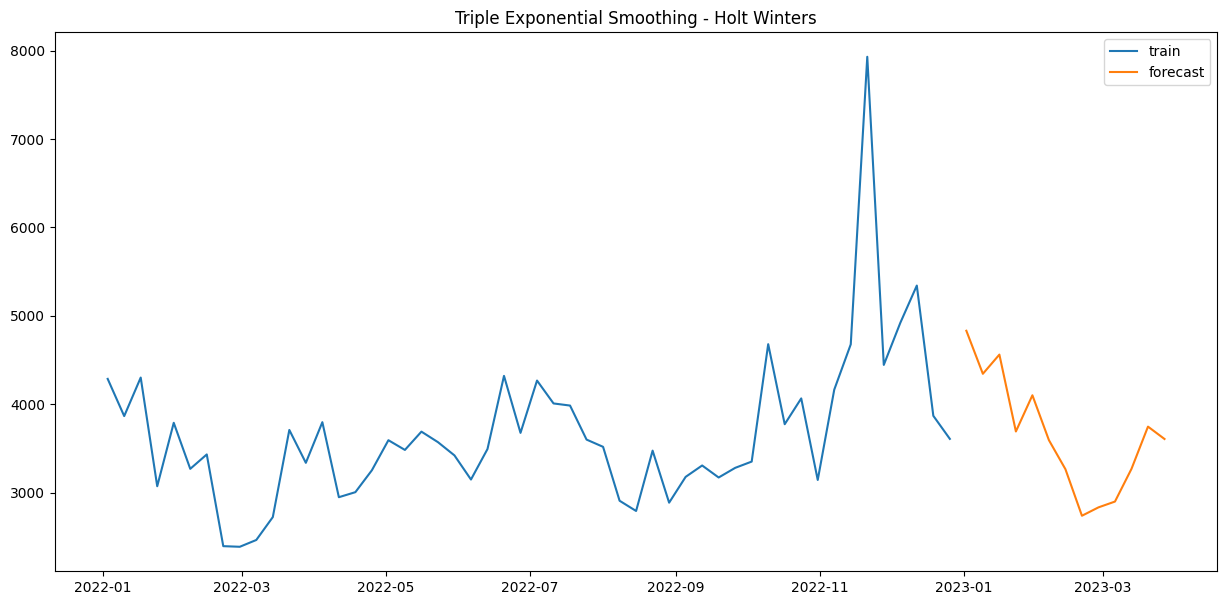

In [45]:
plot_future_predictions(X.loc['2022'],forecast)

# Let's go back to the bitcoin dataset...

In [50]:
df_btc = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Time Series Analysis/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters/bitcoin_price.csv',index_col='Date',parse_dates=True)['Adj Close']
df_btc.head()

,Adj Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [53]:
# Set the frequency of the index to 'daily'.

df_btc = df_btc.asfreq('D')
df_btc.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

# Model Assessment

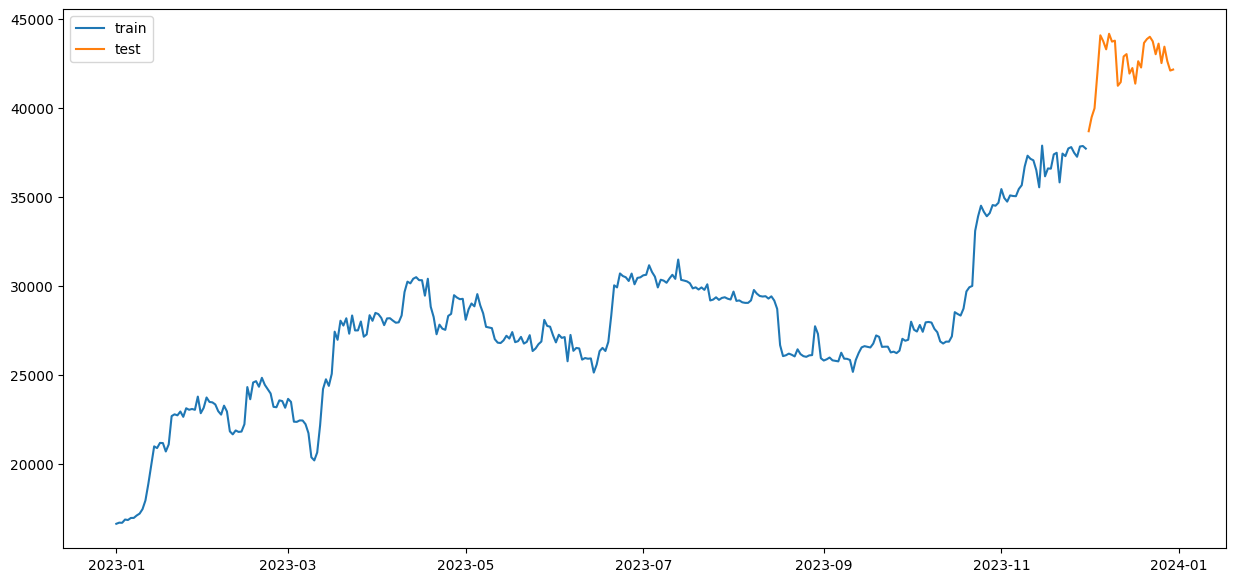

In [55]:
# Set the test data period to the last 30 days

periods = 30
train = df_btc[:-periods]
test = df_btc[-periods:]
plt.figure(figsize=(15,7))
plt.plot(train.loc['2023'], label='train')
plt.plot(test, label='test')
plt.legend()
plt.show()

In [67]:
# Build a Holt-Winters model

hw_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365).fit()
print(hw_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                Adj Close   No. Observations:                 3362
Model:             ExponentialSmoothing   SSE                     2492932577.661
Optimized:                         True   AIC                          46180.252
Trend:                         Additive   BIC                          48438.640
Seasonal:                Multiplicative   AICC                         46272.568
Seasonal Periods:                   365   Date:                 Thu, 10 Jul 2025
Box-Cox:                          False   Time:                         16:49:51
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9242857                alpha                 True
smoothing_trend       

In [68]:
# Make predictions

hw_pred = hw_model.predict(start=test.index[0], end=test.index[-1])
hw_pred

,0
2023-12-01,37742.380375
2023-12-02,37773.718336
2023-12-03,38441.647619
2023-12-04,38392.702439
2023-12-05,40312.096645
2023-12-06,43985.090329
2023-12-07,44401.227329
2023-12-08,43437.353336
2023-12-09,43485.353777
2023-12-10,44339.711565


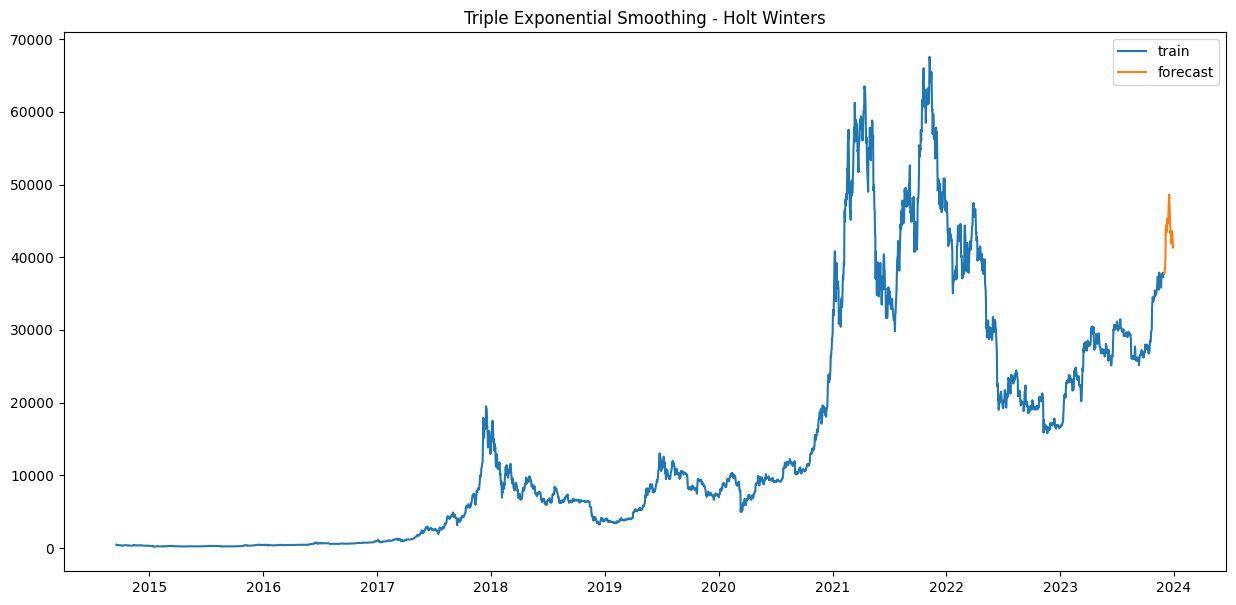

In [69]:
plot_future_predictions(train,hw_pred)

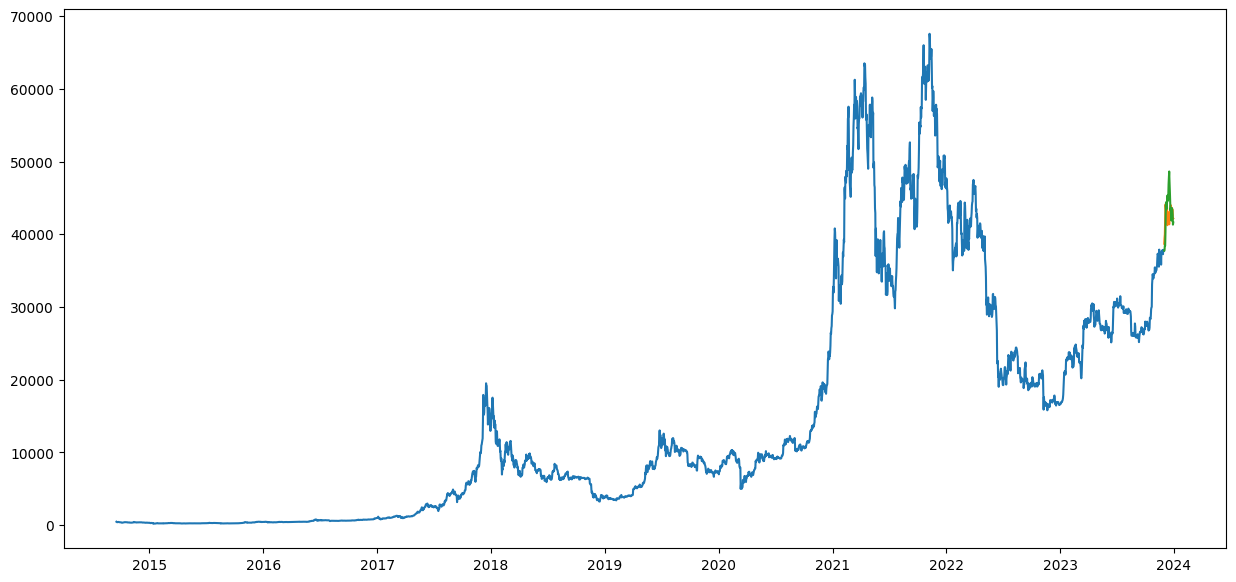


MAPE: 4.65%
MAE: 1958.67
RMSE: 2704.45




In [70]:
# Calculate model performance

model_assess(train, test, hw_pred)